# Translation, Rotation, and Scaling

First, let's define some useful data structures and functions. Tuple 'Point' represents a point in 2D space and has 'x', 'y', coordinates.

In [1]:
%matplotlib inline
from utils import draw, polygon, get_corners
import math

In [2]:
import collections
Point = collections.namedtuple('Point', 'x y')

Tuple 'RefPoint' represents a reference point within a floor plan. A reference point consists of two points, 'old' and 'new'. The 'old' point is the point in the original reference frame. The 'new' point represents a correspoding point in the new reference frame.

In [3]:
RefPoint = collections.namedtuple('RefPoint', 'old new')

Tuple 'Rect' represents a rectangle identified by its bottom-left and upper-right corner points. The bottom-left corner point is stored in property 'bl'. The upper-right corner point is stored in property 'ur'. 

In [4]:
Rect = collections.namedtuple('Rect', 'bl ur')

The 'Rect' data structure can only be used to represent rectangles with purely vertical and horizontal edges. A rotated rectangle can have edges with arbitrary slopes and such rectangle needs to be represented by all 4 corner points. The following function converts a Rect object into a list of four points representing its edges.

Next, we initialize matplotlib and define a couple of utility functions that will allow us to plot graphs of rectangles. The function outline converts a rectangle represent by its four corners into a list of coordinates understood by matplotlib. The function draw will draw a rectangle represented by val. The argument val can be either a 'Rect' object (if corners=False), or a list of four corner points (if corners=True).

Let's create our first floor plan. Our floor plan will be 1000 pixels wide and 500 pixels tall. We will represent it with variable 'plan' which will be a 'Rect' object.

In [5]:
width = 1000
height = 500

plan = polygon(get_corners(Rect(bl=Point(x=0, y=0), ur=Point(x=width, y=height))))

Let's draw our rectangle (floor plan) to see what that would look like. Note that both our axes start at -500 to give ourselves some space to the left and bottom of the rectangle. The rectangle's bottom-left corner is at the origin. The rectangle's upper-right corner is at (1000, 500).

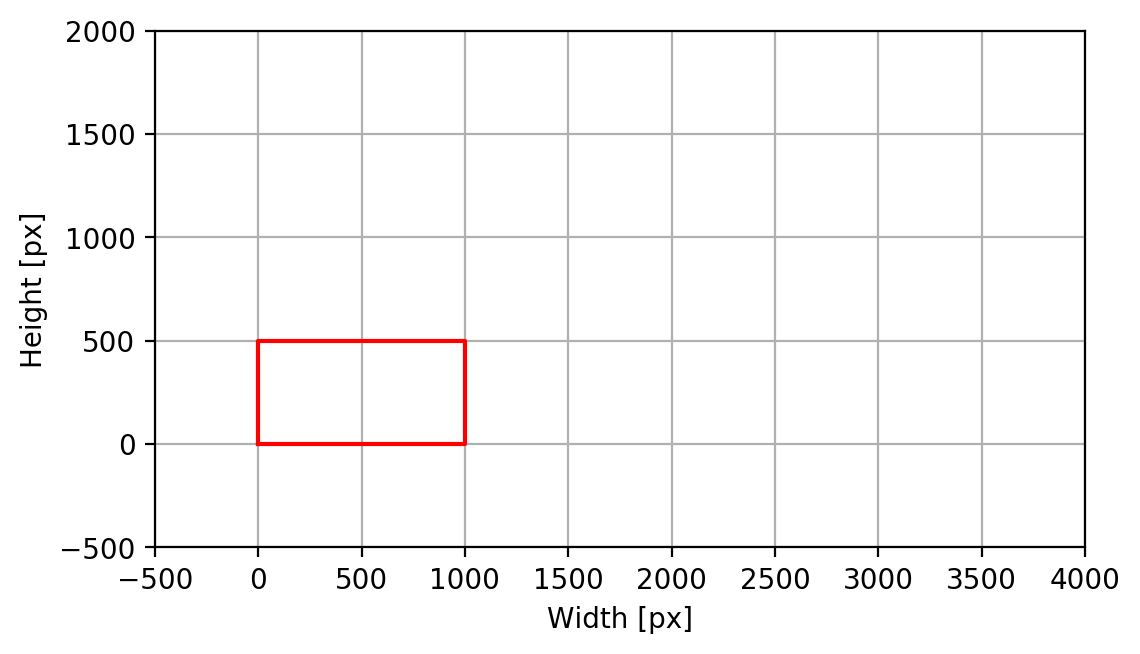

In [6]:
draw(plan)

Next, let's define a simple function that will allow us to shift the rectangle by an arbitrary number of points along the x and y axes.

In [7]:
def shift_polyline(polyline, dx, dy):
    return [Point(p.x + dx, p.y + dy) for p in polyline]

And let's move our floor plan to the right and up a bit to see if the function works.

In [8]:
draw(shift_polyline(plan, 100, 100))

So far so good. Next, we will create a function to scale the rectangle by an arbitrary factor. If the factor is > 1, the rectangle will be enlarged. If the factor is < 1, the rectangle will be shrunk. In both cases, the location of the rectangle's center will not change.

In [9]:
def _middle(a, b):
    return (b - a) / 2 + a

def line_center(a, b):
    return Point(x=_middle(a.x, b.x), y=_middle(a.y, b.y))

def scale_point(point, factor, origin=Point(x=0, y=0)):
    return Point(x=origin.x + (point.x - origin.x) * factor, y=origin.y + (point.y - origin.y) * factor)

def scale_polyline(polyline, factor):
    center = line_center(polyline[0], polyline[2])
    return [scale_point(p, factor, origin=center) for p in polyline]

And let's test it out by making the floor plan somewhat smaller. Note that its center is still at (500, 250) like before.

In [10]:
draw(scale_polyline(plan, 0.5))

Let's create a function that would allow us to rotate the rectangle by an arbitrary number of degrees around the rectangle's center. Note that this function no longer returns a Rect object. It must return a list of all four points (see above).

In [11]:
def rotate_point(point, angle, origin=Point(x=0, y=0)):
    return Point(x=origin.x + math.cos(angle) * (point.x - origin.x) - math.sin(angle) * (point.y - origin.y),
                 y=origin.y + math.sin(angle) * (point.x - origin.x) + math.cos(angle) * (point.y - origin.y))

def rotate_polyline(polyline, angle):
    origin = line_center(polyline[0], polyline[2])
    return [rotate_point(p, angle, origin=origin) for p in polyline]

And let's rotate our floor plan by 45 degrees clockwise.

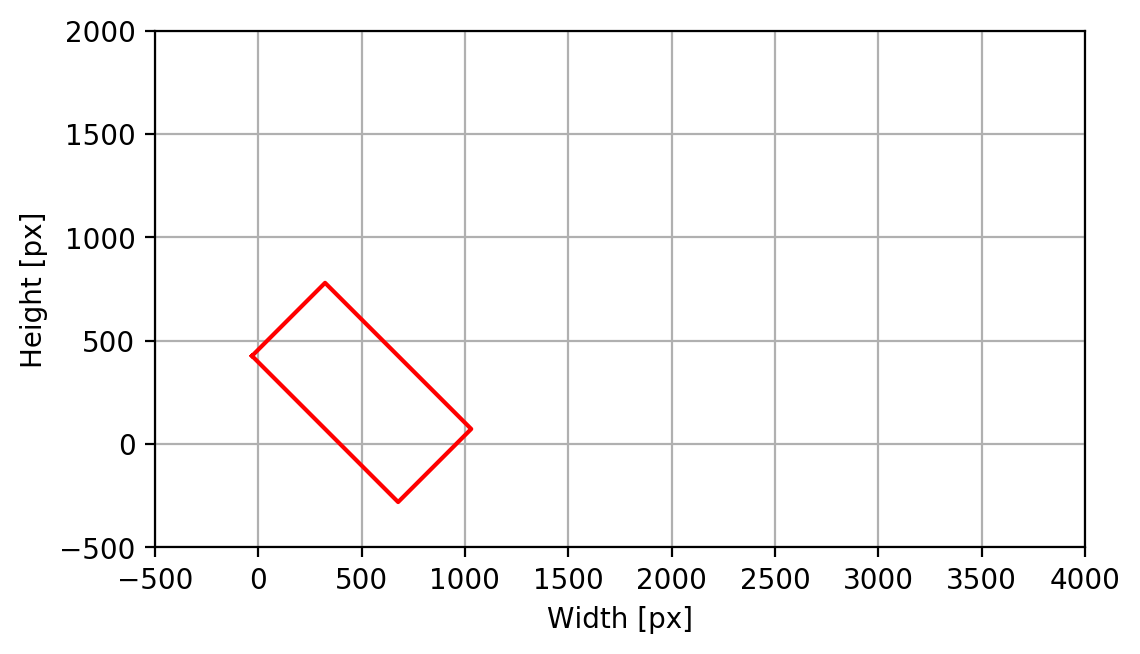

In [12]:
draw(rotate_polyline(plan, math.radians(-45)))

We now have three transformations that we can apply to a rectangle: shift, scale, and rotate. Let's see if we can combine all three of them and apply to our floor plan.

In [13]:
draw(rotate_polyline(shift_polyline(scale_polyline(plan, 1.5), 2000, 1000), math.radians(-30)))

Seems to work! Our original floor plan has been shifted, enlarged, and rotated. This gives us quite a bit of flexibility. With these three operations, we can align the floor plan with a map in pretty much any way we want. The only thing that we need to do is find a way to calculate the three parameters (shift, scale, rotation) from two reference points. 

So, let's define some reference points. For simplicity, we will assume that both our reference points will be aligned with the floor plan's corners. Reference point A will be the bottom-left corner. Reference point B will be the upper-right corner. Generalizing this to reference points that are not aligned with the floor plan's corners, i.e., to points within the floor plan, is trivial and you can do that later.

We created the previous diagram by manually specifying the parameters scale=1.5, shift=(2000,1000), rotate=-30. This generated a bottom-left corner at (1662.9809471616709,1300.2404735808354) and an upper-right corner at (3337.019052838329,1199.7595264191646). (I found out by modifying the draw function to print all coordinates it was plotting). So, we will define two reference points with those two coordinates and see if we can get the same diagram as above.

In [14]:
ref_a = RefPoint(old=Point(x=0,       y=0),        new=Point(x=1662.9809471616709, y=1300.2404735808354))
ref_b = RefPoint(old=Point(x=width-1, y=height-1), new=Point(x=3337.019052838329,  y=1199.7595264191646))

Obtaining the scale parameter value is easy. We measure the length of the diagonal line in the old rectangle and in the new rectangle and divide the two.

In [15]:
def distance(a, b):
    '''Find euclidian distance between points 'a' and 'b'
    '''
    return ((b.x - a.x)**2 + (b.y - a.y)**2)**0.5


def scale(ref_a, ref_b):
    '''Find the scaling factor using two reference points 'ref_a' and 'ref_b'
    '''
    old_distance = distance(ref_a.old, ref_b.old)
    new_distance = distance(ref_a.new, ref_b.new)
    return new_distance / old_distance

And let's test it right away. If it works, we should get the original scaling factor 1.5 back.

In [16]:
print(scale(ref_a, ref_b))

1.5018020421620901


The next parameter we need is shift. Shift is easily obtained from the center points of the old and new rectangles. Those center points are easily calculated from the diagonal lines.

In [17]:
def shift(ref_a, ref_b):
    old_center = line_center(ref_a.old, ref_b.old)
    new_center = line_center(ref_a.new, ref_b.new)
    return (new_center.x - old_center.x, new_center.y - old_center.y)

print(shift(ref_a, ref_b))

(2000.5, 1000.5)


The final parameter we need to calculate is rotation. To know how much to rotate, we measure the angle of the old diagonal and the angle of the new diagonal. Then we subtract the two.

In [18]:
def _angle(width, height):
    return math.atan(height / width)

def rotate(ref_a, ref_b):
    old_angle = _angle(ref_b.old.x - ref_a.old.x, ref_b.old.y - ref_a.old.y)
    new_angle = _angle(ref_b.new.x - ref_a.new.x, ref_b.new.y - ref_a.new.y)
    return new_angle - old_angle;

print(math.degrees(rotate(ref_a, ref_b)))

-29.977054154405298


And let's create a combined function which puts all this together. The function will take as parameters the original rectangle and the two reference points. It will spit out a new rectangle in the new reference frame determined by the two reference points. If we draw the result, we will hopefully get the same diagram as above (because we set our reference points to match it).

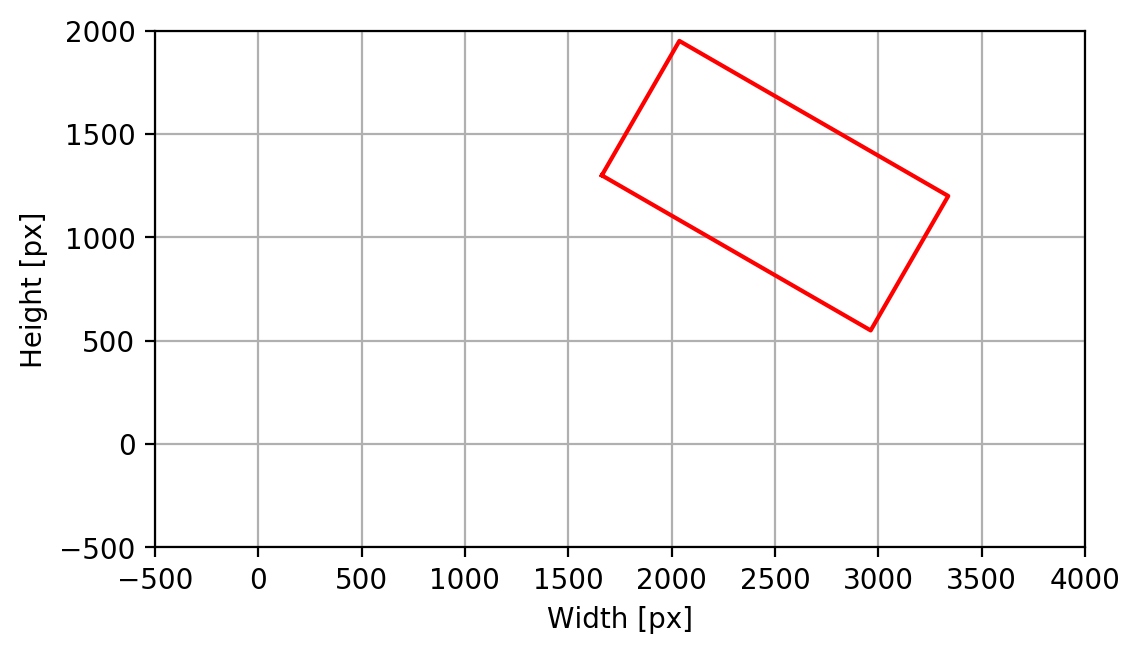

In [19]:
def translate_polyline(polyline, ref_a, ref_b):
    zoom = scale(ref_a, ref_b)
    dx, dy = shift(ref_a, ref_b)
    angle = rotate(ref_a, ref_b)
    new_polyline = rotate_polyline(shift_polyline(scale_polyline(polyline, zoom), dx, dy), angle)    
    return new_polyline

draw(translate_polyline(plan, ref_a, ref_b))

Voilla! The only thing that is missing is a function that we can use to translate the coordinates of an arbitrary point within the floor plan to the new coordinate system defined by ref_a and ref_b. Let's try to translate a point that is 2/3 of the width and 2/3 of the height from the rectangle's bottom-left corner.

In [20]:
point = Point(x=width * 2 / 3, y=height * 2 / 3)
draw(plan, point=point)

The approach will be very similar to what we have done so far. We use the two reference points to obtain the scaling factor, shift, and rotation. We then apply those to our selected point and use the center of the transformed rectangle as the rotation origin.

In [21]:
def translate_point(point, ref_a, ref_b):
    zoom = scale(ref_a, ref_b)
    dx, dy = shift(ref_a, ref_b)
    angle = rotate(ref_a, ref_b)
    
    # Calculate the center of the old rectangle
    old_center = line_center(ref_a.old, ref_b.old)
        
    # Calculate the center of the new rectangle in the target coordinate system
    new_center = line_center(ref_a.new, ref_b.new)
    
    # Scale the original point using the new center as origin
    new_point = scale_point(point, zoom, origin=old_center)
    
    # Shift the new point
    new_point = Point(x=new_point.x + dx, y=new_point.y + dy)
    
    # Rotate the new point using the center of the new rectangle as the origin
    new_point = rotate_point(new_point, angle, origin=new_center)
    
    return new_point

new_point = translate_point(point, ref_a, ref_b)
print("%s -> %s" % (point, new_point))
draw(translate_polyline(plan, ref_a, ref_b), point=new_point)

Point(x=666.6666666666666, y=333.3333333333333) -> Point(x=2780.37387056831, y=1233.6201883000806)


That's it. If you set the reference points' new attributes to longitude / latitude, the above function will translate from the logical coordinates of the floor plan to longitude and latitude.

The only thing that remains to be done is to make it possible for the reference points not to be aligned with the plan's corners. It should be fairly straightforward to extend the functions above to support such scenarios. This is left as an excercise for the reader.

The functions shown here are inefficient, of course. The whole calculation can be done in much more efficient way, but then the education value of working the solution step by step would be lost.